### Join Modeled Streamflow to MERIT Stream Networks

This notebook loads two versions of the MERIT stream network, compares them, and then demonstrates how to join the NCAR modeled hydrology data to the network via `COMID`.

The MERIT network used by NCAR in the model was provided directly by NCAR and is available on Chinook here: `/import/beegfs/CMIP6/arctic-cmip6/Arctic_Rivers_Data`

The MERIT-Plus network is available on ScienceBase here: `https://www.usgs.gov/data/mainstem-rivers-world-based-merit-hydrography-and-natural-earth-names`

In this notebook, all files are loaded from local copies to prevent overloading the login node on Chinook. The `snap-geo` conda environment is used to run this notebook.

Load packages

In [116]:
import geopandas as gpd
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.colors as colors

Load datasets

In [117]:
# MERIT subset used by NCAR for modeling - Alaska-ish domain only
merit = gpd.read_file("/Users/joshpaul/arctic_rivers/AK_Rivers.gpkg")
merit = merit[["COMID", "geometry"]]

# MERIT-Plus dataset with mainstem name attributes from Natural Earth - global domain
merit_plus_global = gpd.read_file("/Users/joshpaul/arctic_rivers/merit_plus.gpkg")
merit_plus_global = merit_plus_global[
    ["comid", "nameID", "gnis_name", "riverID", "geometry"]
]

# one of the output files from the model for demo
q_ds = xr.open_dataset("/Users/joshpaul/arctic_rivers/2050_fC2LE4_Q.nc")

Check the CRS of input geodataframes

In [118]:
merit.crs == merit_plus_global.crs

True

Clip the global MERIT-Plus to the extent of NCAR's model subset.

In [119]:
merit_plus = merit_plus_global.cx[
    merit.total_bounds[0] : merit.total_bounds[2],
    merit.total_bounds[1] : merit.total_bounds[3],
]

Compare the MERIT datasets.

In [120]:
merit_comids = merit.COMID.unique()
merit_plus_comids = merit_plus.comid.unique()

print("Are all merit COMIDs in merit_plus?")
print(set(merit_comids).issubset(set(merit_plus_comids)), "\n")

print("For shared COMIDs, are their geometries equal?")
merged = pd.merge(merit, merit_plus, left_on="COMID", right_on="comid", how="inner")
merged["geometry_equal"] = merged.geometry_x.equals(merged.geometry_y)
print(merged["geometry_equal"].all())

Are all merit COMIDs in merit_plus?
True 

For shared COMIDs, are their geometries equal?
False


How many geometries are not equal?

In [121]:
print(merged["geometry_equal"].value_counts())

geometry_equal
False    34208
Name: count, dtype: int64


All of them! Yikes. But why? Let's plot them to see how they differ visually. This is the Seward Peninsula.

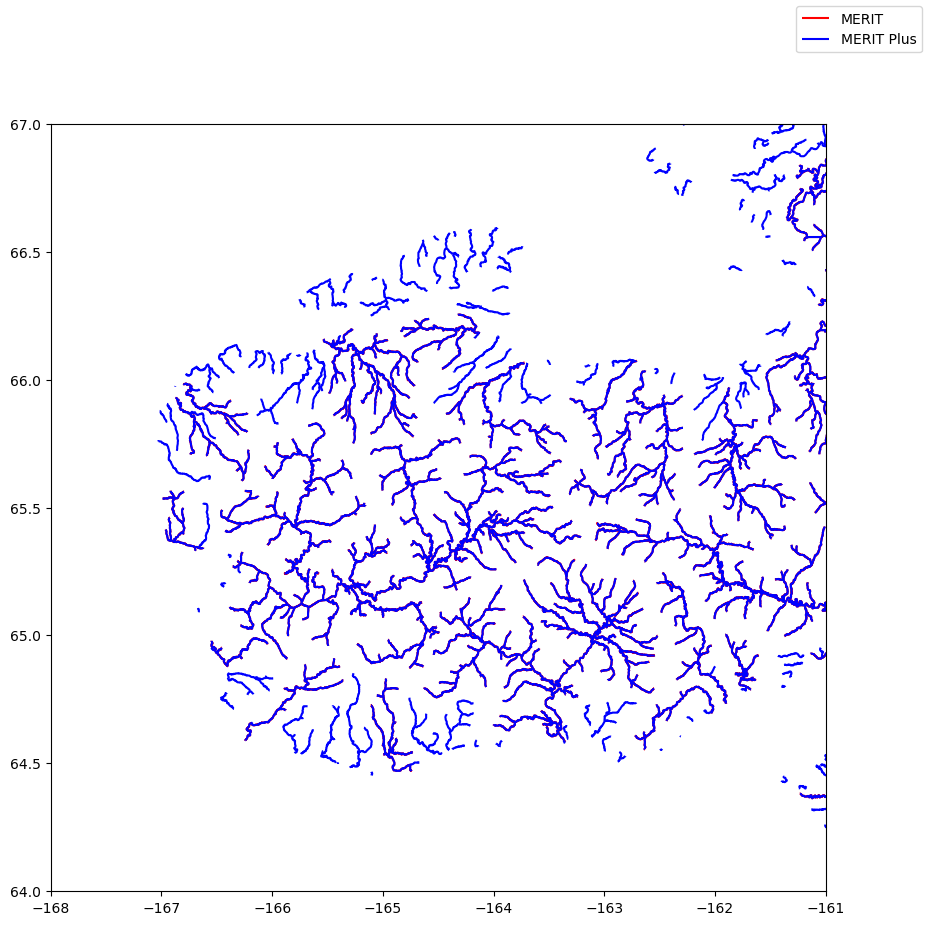

In [122]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlim(-168, -161)
ax.set_ylim(64, 67)

merit.plot(ax=ax, color="red", label="MERIT")
merit_plus.plot(ax=ax, color="blue", label="MERIT Plus")
fig.legend()

They are not drastically different. Let's zoom in a bit more.

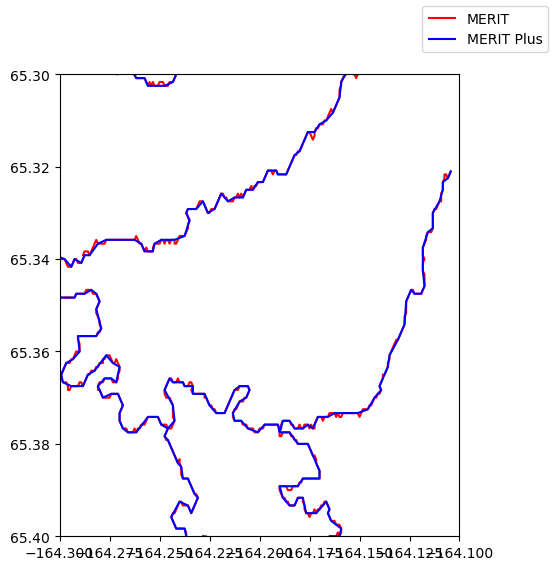

In [123]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.set_xlim(-164.3, -164.1)
ax.set_ylim(65.4, 65.3)

merit.plot(ax=ax, color="red", label="MERIT")
merit_plus.plot(ax=ax, color="blue", label="MERIT Plus")
fig.legend()

OK! The MERIT-Plus dataset is just a simplified geometry, which is good for our purposes. Let's just use MERIT-Plus, because it also has stream names. Let's investigate the fields that may have name attributes.

In [124]:
merit_plus.head()

,comid,nameID,gnis_name,riverID,geometry
2738700,78000001,unknown,None,None,"LINESTRING (-135.77583 59.74500, -135.77750 59..."
2738701,78000002,unknown,None,None,"LINESTRING (-135.66000 59.69083, -135.66500 59..."
2738702,78000003,unknown,None,None,"LINESTRING (-135.62750 59.66083, -135.63083 59..."
2738703,78000004,unknown,None,None,"LINESTRING (-135.91667 59.76750, -135.91750 59..."
2738704,78000005,unknown,None,None,"LINESTRING (-136.58750 59.78833, -136.58500 59..."


In [125]:
print(merit_plus["riverID"].unique())
print(merit_plus["gnis_name"].unique())
print(merit_plus["nameID"].unique())

[None '158' '1009' '438' '1008' '239' '240' '757' '53' '238' '532' '234'
 '1010' '617' '596' '235' '756' '237' '236' '61' '639' '34' '472' '1011'
 '281']
[None]
['unknown' 'Stikine' 'Meade' 'Colville' 'Sagavanirktok' 'Porcupine'
 'Koyukuk' 'Kobuk' 'Yukon' 'Tanana' 'Stewart' 'Kuskokwim'
 'S. Fork Kuskokwim' 'White' 'Donjek' 'North Fork Kuskokwim' 'Pelly'
 'Susitna' 'Copper' 'Teslin' 'Iliamna Lake Outlet' 'Mackenzie'
 'Arctic Red' 'South Nahanni' 'Liard']


`riverID` is not a meaningful field.

There are no `gnis_name` entries, because those are derived from the NHDPlus dataset which is not available in Alaska!

The name info is only in the `nameID` field, which is derived from Natural Earth features, and unfortunately only the largest rivers are included here! Might not be that useful for name attributes, but we might benefit from the simplified linework.

Now let's join some data to the stream network and plot it.

In [126]:
# grab some data from July 1, 2050 and create a new dataframe with the COMIDs and flow values
q_df = pd.DataFrame(
    {
        "COMID": q_ds["IRFroutedRunoff"].sel(time="2050-07-01").seg.values,
        "Q": q_ds["IRFroutedRunoff"].sel(time="2050-07-01").values[0],
    },
)

In [127]:
q_df.head()

,COMID,Q
0,81020252,2.628675
1,81020426,1.583704
2,81020442,1.007815
3,81020575,32.773907
4,81020586,18.484976


In [128]:
# join the dataframe to the geodataframes
merit_q_gdf = gpd.GeoDataFrame(
    q_df.merge(merit_plus, left_on="COMID", right_on="comid"), geometry="geometry"
)
merit_q_gdf.head()

,COMID,Q,comid,nameID,gnis_name,riverID,geometry
0,81020252,2.628675,81020252,unknown,None,None,"LINESTRING (-145.94250 62.92000, -145.93917 62..."
1,81020426,1.583704,81020426,unknown,None,None,"LINESTRING (-146.37500 62.89333, -146.37333 62..."
2,81020442,1.007815,81020442,unknown,None,None,"LINESTRING (-145.99333 62.87500, -145.99500 62..."
3,81020575,32.773907,81020575,unknown,None,None,"LINESTRING (-144.02500 62.98500, -144.02167 62..."
4,81020586,18.484976,81020586,unknown,None,None,"LINESTRING (-145.51833 63.02417, -145.51917 63..."


Plotted with standard colormap doesn't look great because so many streams have low flow.

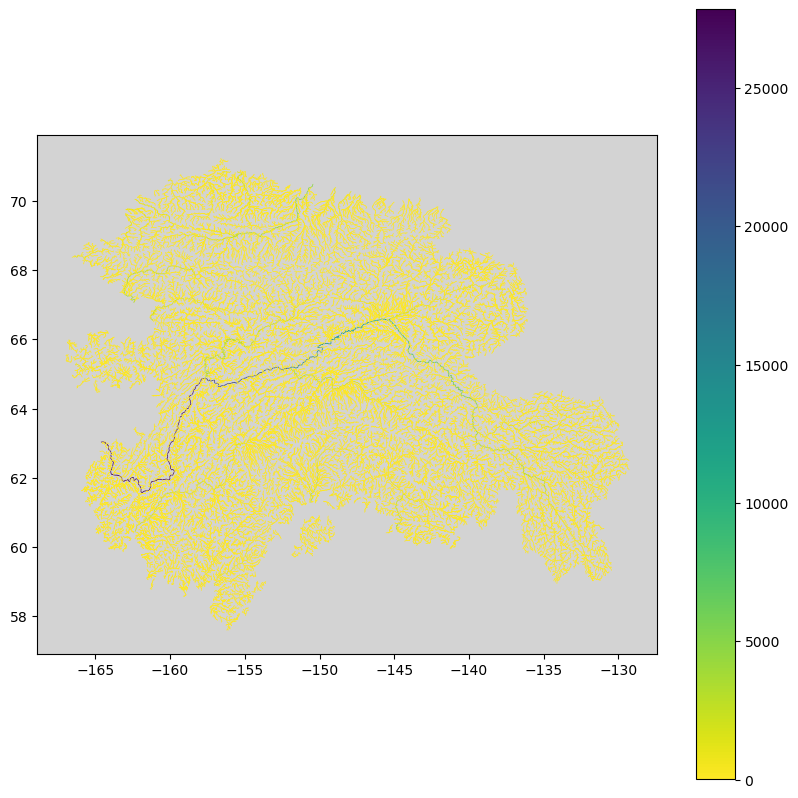

In [129]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merit_q_gdf.plot(
    ax=ax,
    column="Q",
    linewidth=0.5,
    cmap="viridis_r",
    # norm=colors.LogNorm(vmin=merit_q.Q.min(), vmax=merit_q.Q.max()),
    legend=True,
)
ax.set_facecolor("lightgray")

Plotted with a log scale colormap looks better!


Text(0.5, 1.0, 'NCAR Arctic Rivers Dataset:\n Modeled Streamflow (m3/s^2) 7/1/2050')

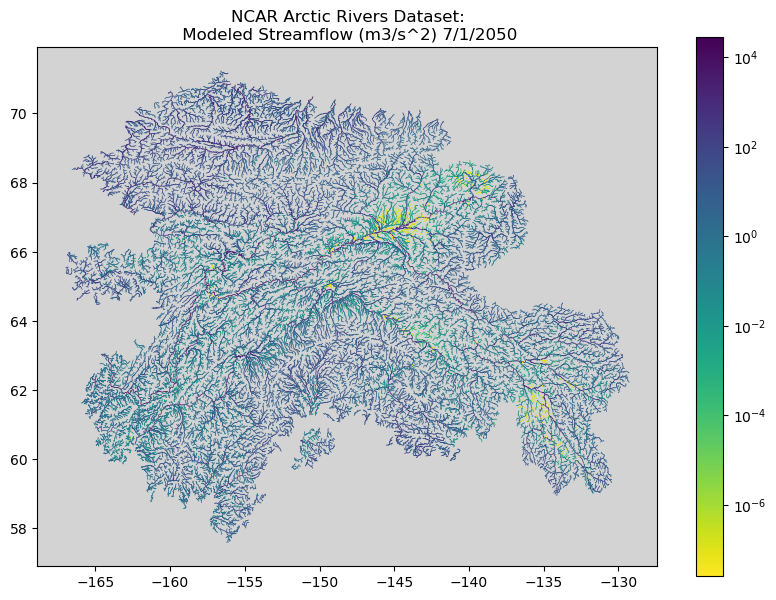

In [130]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
merit_q_gdf.plot(
    ax=ax,
    column="Q",
    linewidth=0.5,
    cmap="viridis_r",
    norm=colors.LogNorm(vmin=merit_q_gdf.Q.min(), vmax=merit_q_gdf.Q.max()),
    legend=True,
)
ax.set_facecolor("lightgray")

ax.set_title("NCAR Arctic Rivers Dataset:\n Modeled Streamflow (m3/s^2) 7/1/2050")